In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kaggle = pd.read_csv('./datasets/kaggle_preprocessed.csv',index_col='Id')

In [3]:
kaggle.head(3)

,3Ssn Porch,Alley_Grvl,Alley_None,Alley_Pave,Bedroom AbvGr,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,...,Street_Pave,TotRms AbvGrd,Total Bsmt SF,Total Living Space_morethan10k,Utilities_AllPub,Utilities_NoSewr,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold
Id,,,,,,,,,,,,,,,,,,,,,
2658,0,1,0,0,4,0,1,0,0,0,...,1,9,1020,False,1,0,0,1910,1950,2006
2718,0,0,1,0,6,0,0,1,0,0,...,1,10,1967,False,1,0,170,1977,1977,2006
2414,0,0,1,0,3,1,0,0,0,0,...,1,7,654,False,1,0,100,2006,2006,2006


In [4]:
kaggle.shape

(879, 309)

In [5]:
raw = pd.read_csv('./datasets/good_cols.csv',index_col='Id')

In [6]:
raw.shape

(2049, 310)

In [7]:
X = raw.drop('SalePrice', 1)
y = raw['SalePrice']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [9]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [10]:
alpha = 2300
lasso = Lasso(alpha=alpha,random_state=420)
y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
coeff_used = np.sum(lasso.coef_!=0)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)
print("number of features used: for alpha =2300:", coeff_used)

Lasso(alpha=2300, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=420,
   selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.903812
number of features used: for alpha =2300: 39


In [11]:
mean_squared_error(y_test,y_pred_lasso) ** .5

24812.590998741907

In [12]:
lasso.intercept_

182080.55174927114

In [13]:
preds = lasso.predict(ss.transform(kaggle))

In [14]:
pd.DataFrame(preds, index=kaggle.index, columns=['SalePrice']).to_csv('kaggle_results.csv')

In [15]:
kaggle.shape

(879, 309)

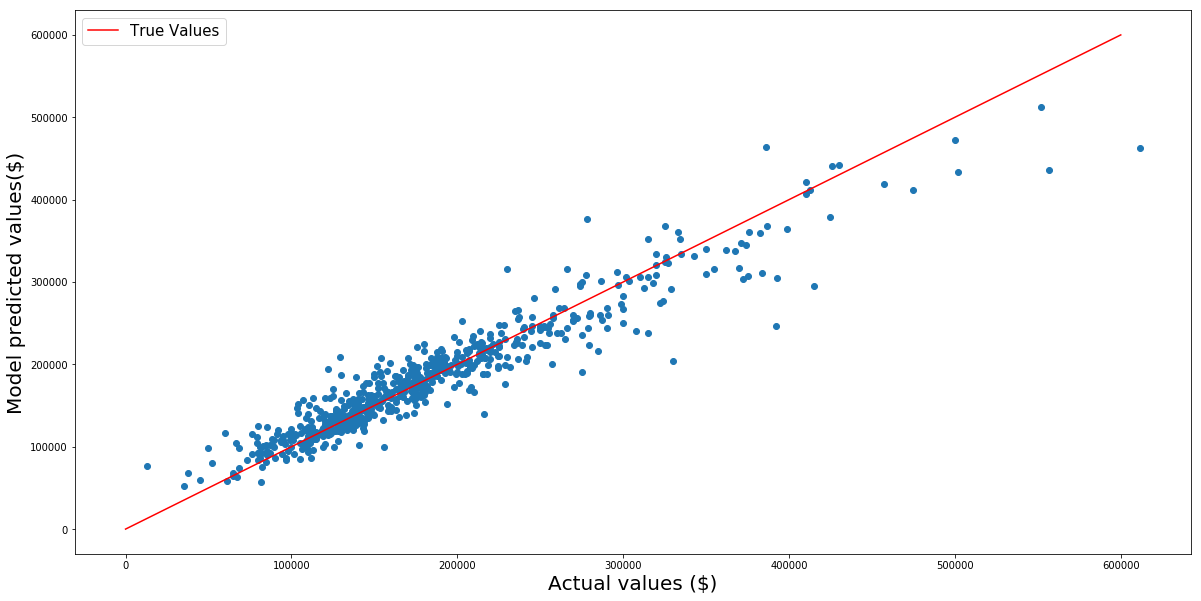

In [17]:
plt.figure(figsize=(20, 10))
plt.scatter(y_test, lasso.predict(X_test))
plt.ylabel('Model predicted values($)', fontsize=20)
plt.xlabel('Actual values ($)', fontsize=20)
plt.plot([0, 600000], [0, 600000], color='r')

plt.legend(['True Values'],fontsize=15)
plt.show()

Looks like the model did very well from the 100,000 to 200,000 range, but struggled with higher values. Since the higher values are outliers, that's not incredibly suprising. I'm happy with this model!

In [18]:
neg_coefs = pd.Series(lasso.coef_, index=X.T.index.tolist()).sort_values()[:10]
good_coefs = pd.Series(lasso.coef_, index=X.T.index.tolist()).sort_values(ascending=False)[:10]
good_coefs = good_coefs.sort_values()
neg_coefs = neg_coefs.sort_values(ascending=False)

Text(26000, 0.6, 'RMSE: $22922')

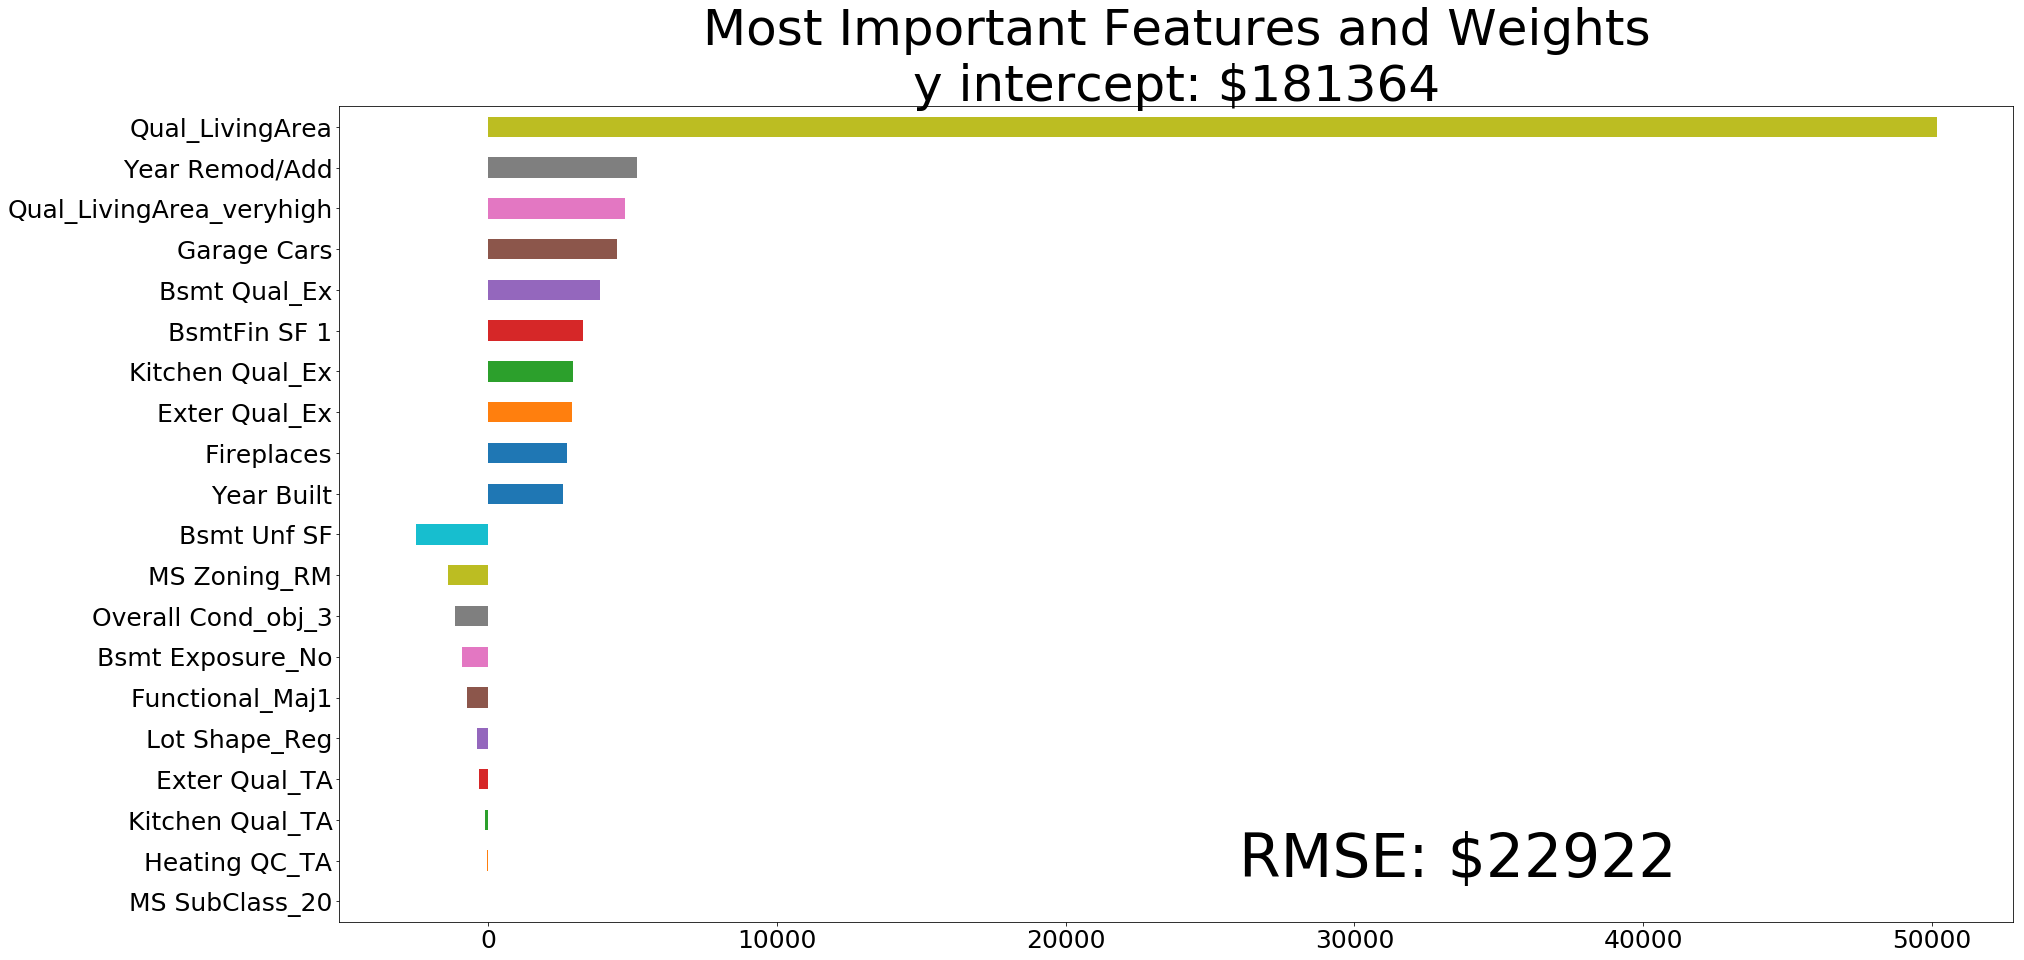

In [19]:
ax = pd.concat([neg_coefs,good_coefs]).plot.barh(figsize=(30, 15))

ax.tick_params(axis='both', labelsize=25)

ax.set_title('Most Important Features and Weights\ny intercept: $181364',fontsize=50)

ax.text(26000, .6, 'RMSE: $22922',fontsize=60)

I think that the model makes sense; Qual_LivingArea has definitely seemed like the most important. Adding the "Qual_LivingArea_veryhigh" variable looks like it may have helped with the higher level values, rather than hurt.

And looking at the plot below of Sale Prices, all values past $350,000 or so are extreme outliers, so it shouldn't be expected that the model would be able nail all of the higher level browsers.

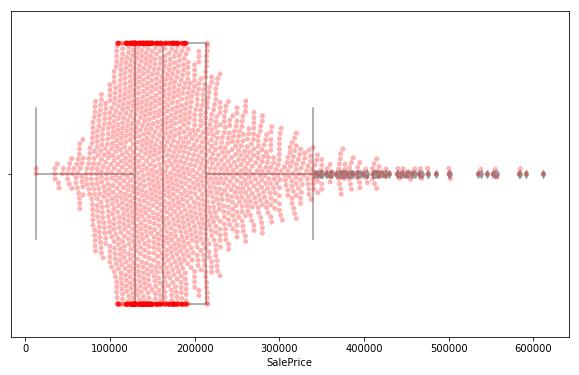

In [20]:
plt.figure(figsize=(10, 6))

ax1 = sns.swarmplot(raw['SalePrice'], color='red', alpha=.3)

ax2 = sns.boxplot(raw['SalePrice'], color='white')

## Beta Values for the Model

In [22]:
coeff_scores = lasso.coef_
coeff = pd.Series(X.T.index.tolist())
beta_scores = pd.DataFrame(coeff_scores)
beta_scores['Attribute'] = coeff
beta_scores.columns = ['BetaVal','Attribute']
beta_scores.sort_values('BetaVal',ascending=False).head()

,BetaVal,Attribute
276,50185.826467,Qual_LivingArea
307,5159.777866,Year Remod/Add
278,4750.776503,Qual_LivingArea_veryhigh
125,4444.294601,Garage Cars
21,3863.853821,Bsmt Qual_Ex
